In [1]:
# import all the required libraries
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from pulp import *

In [2]:
# nodes 
with open("fb-pages-food.nodes",'r', encoding='cp850') as f:
    fb_nodes = f.read().splitlines() 

# connections between nodes
with open("fb-pages-food.edges",'r', encoding='cp850') as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [3]:
fb_nodes

['id,name,new_id',
 '402449106435352,Josh Marks,386',
 '368969274888,Blue Ribbon Restaurants,473',
 '765596333518863,Pat Neely,1',
 '136870209668885,La Griglia,542',
 '840078802741859,Jose Garces,189',
 '1189829367698904,Zac Kara,454',
 '215489785145883,Big Fish Seafood Bistro,158',
 '433538630049239,Tom Aikens,248',
 '146652628707081,The Habit Burger Grill,537',
 '284470611661731,Chef Sheldon Simeon,293',
 '168915784243,Ochikeron,171',
 '178418212291848,Taco Bell Cyprus,485',
 '215200481848118,Christophe Michalak,258',
 "133057950088963,Peohe's,534",
 '274142849334913,Destino Ibiza,500',
 '207168969380470,KFC,194',
 '678736412139674,Chef Shirley Chung,34',
 '1481604538744306,Doug Adams,465',
 '125961667571000,Î×Î®Îö Î®ÎÆÎæ / Moshe Segev,562',
 '343048765743868,Angel Leon Gonzalez,511',
 '194555017235078,Ben Ebbrell - Sorted Chef,201',
 "29803936348,Dick's Drive In Restaurant,188",
 '456610207704498,John Whaite,440',
 '58711572016,Andy Luotto,484',
 '277604159038202,Antonino Cannavacci

In [4]:
# create a dataframe for all the connections in the form of data frame
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
    node_list_1.append(i.split(',')[0])
    node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 886518.55it/s]


In [5]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


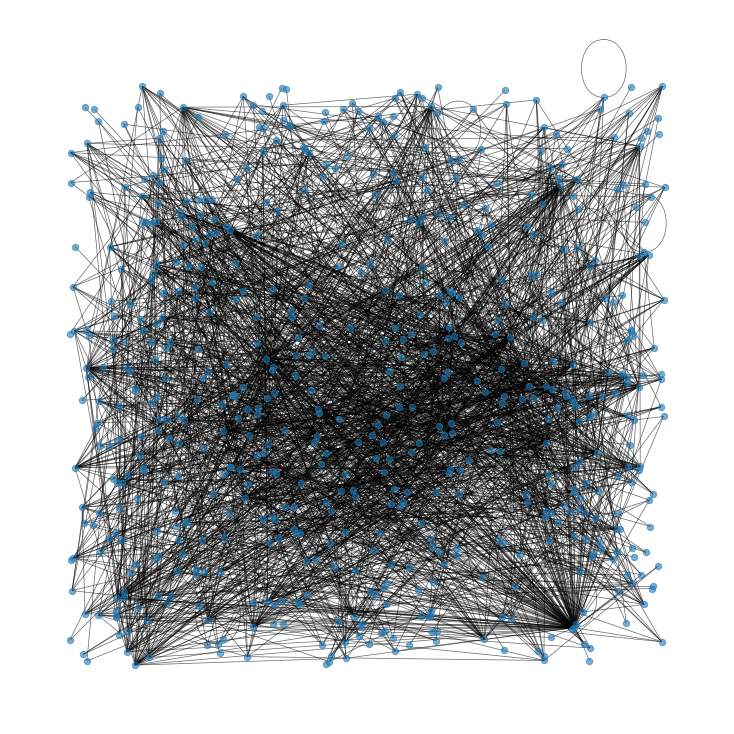

In [6]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

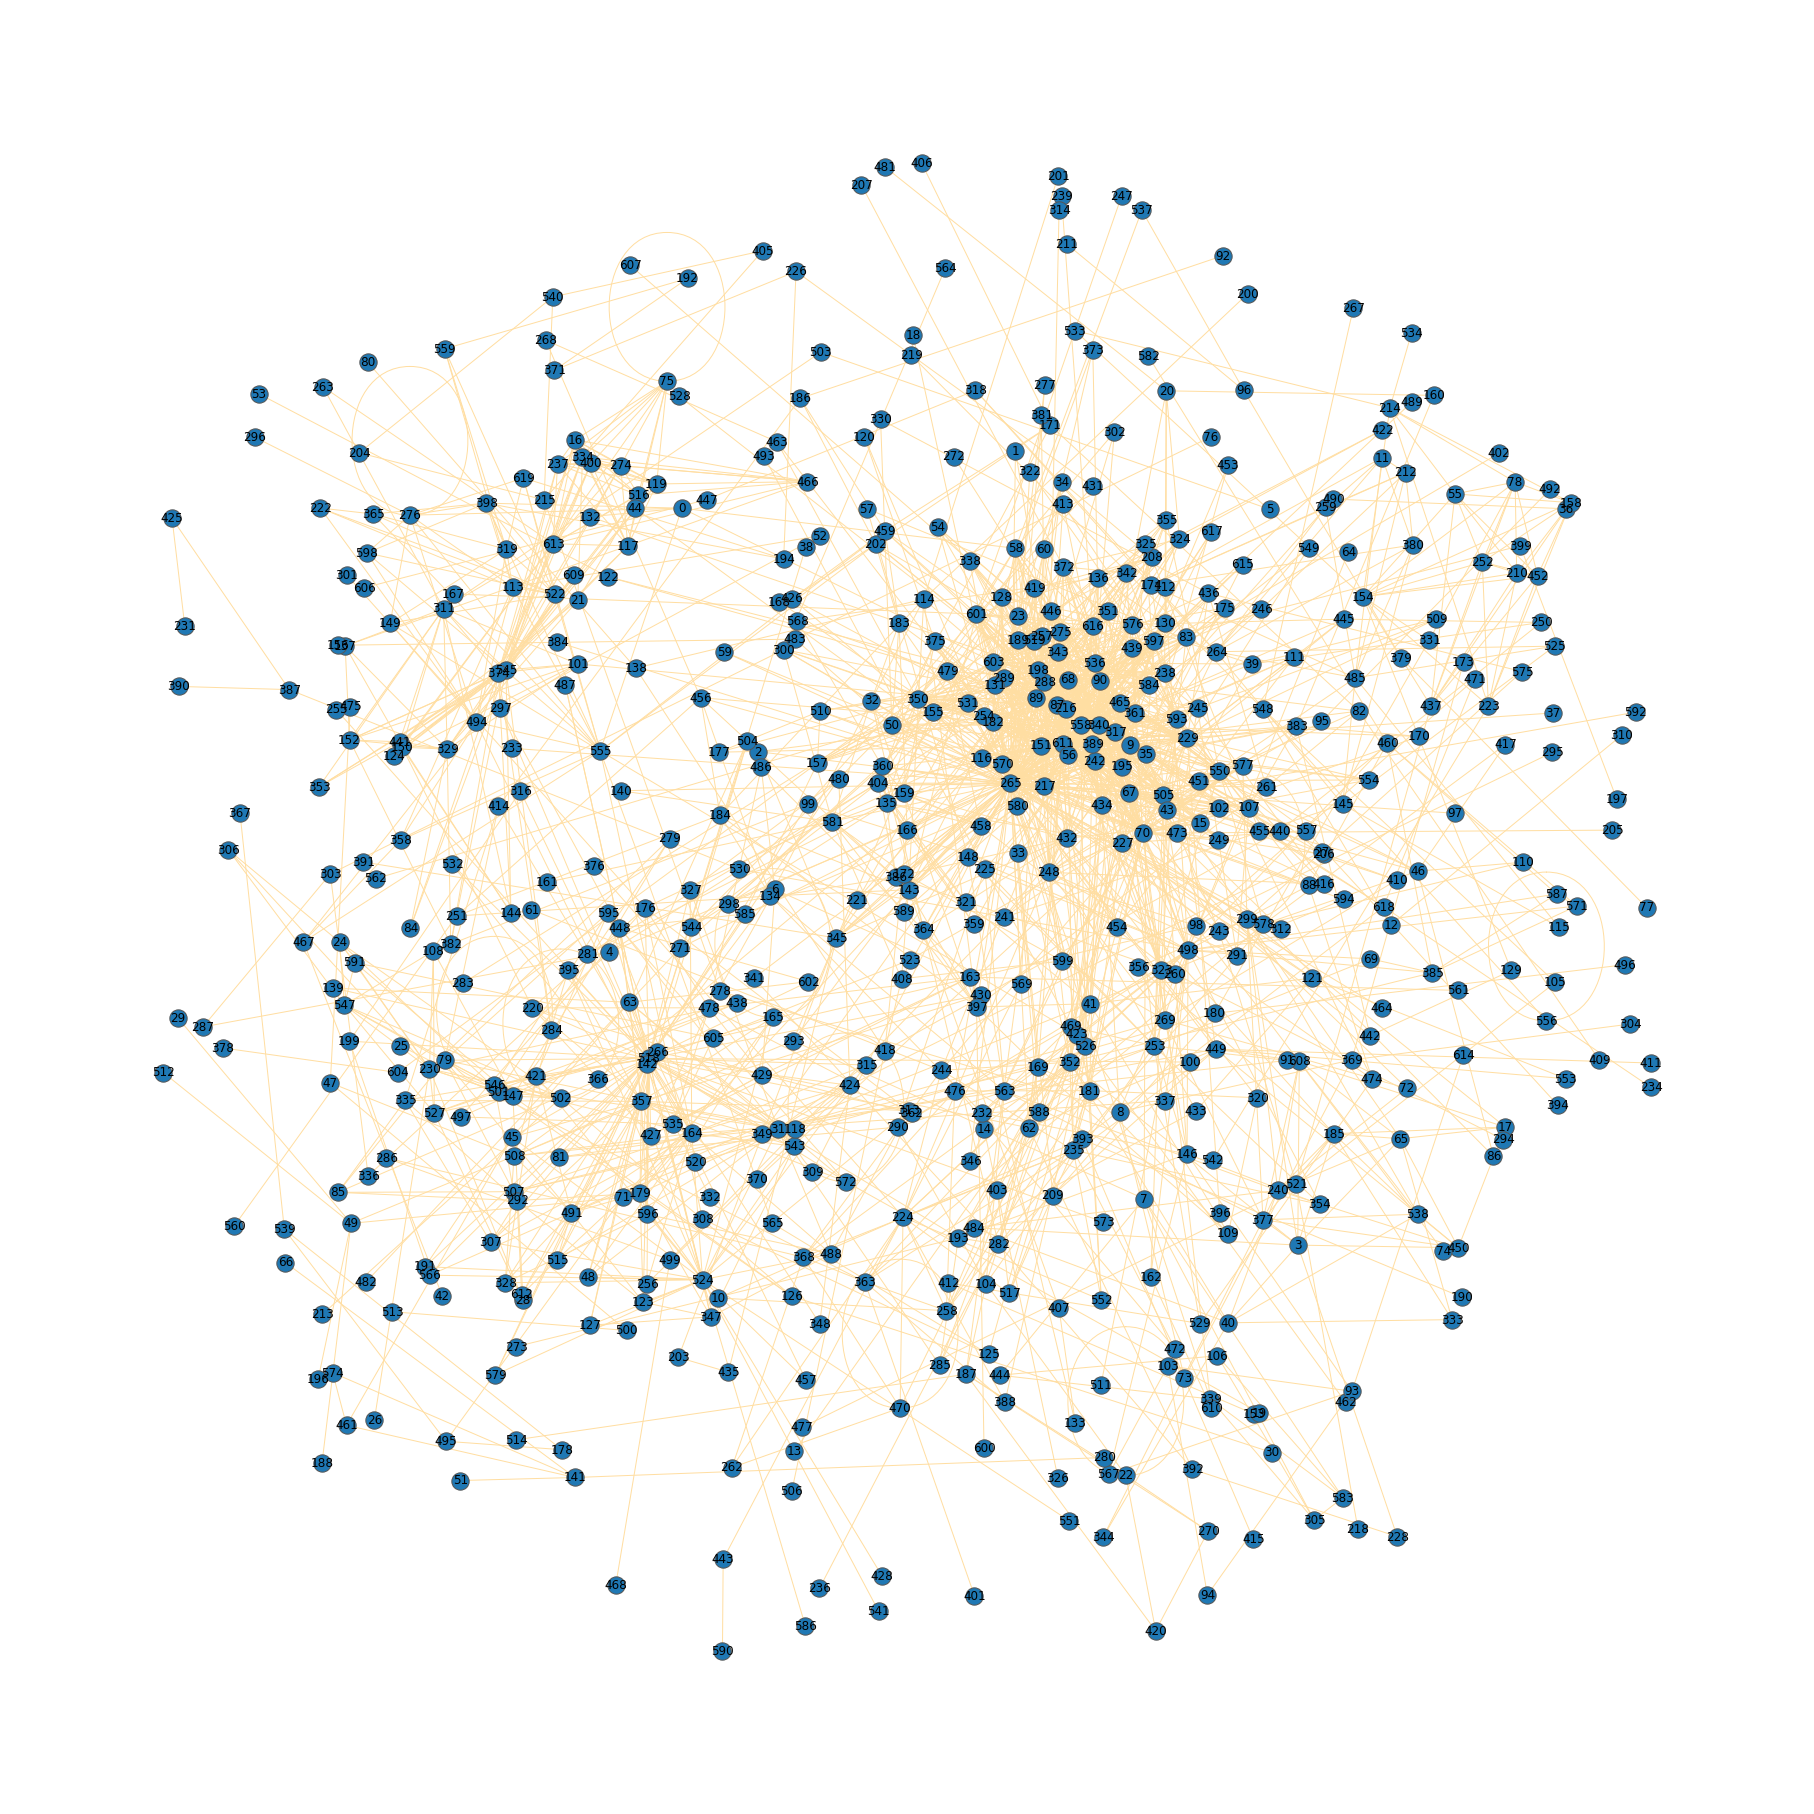

In [7]:
color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
             13:'#d6dcff', 14:'#d2f5f0'} 

plt.figure(figsize=(25,25))
options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}
#colors = [color_map[G.node[node]['group']] for node in G]
#sizes = [G.node[node]['nodesize']*10 for node in G]

"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
default k=0.1 and iterations=50
"""
nx.draw(G, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 
plt.show()

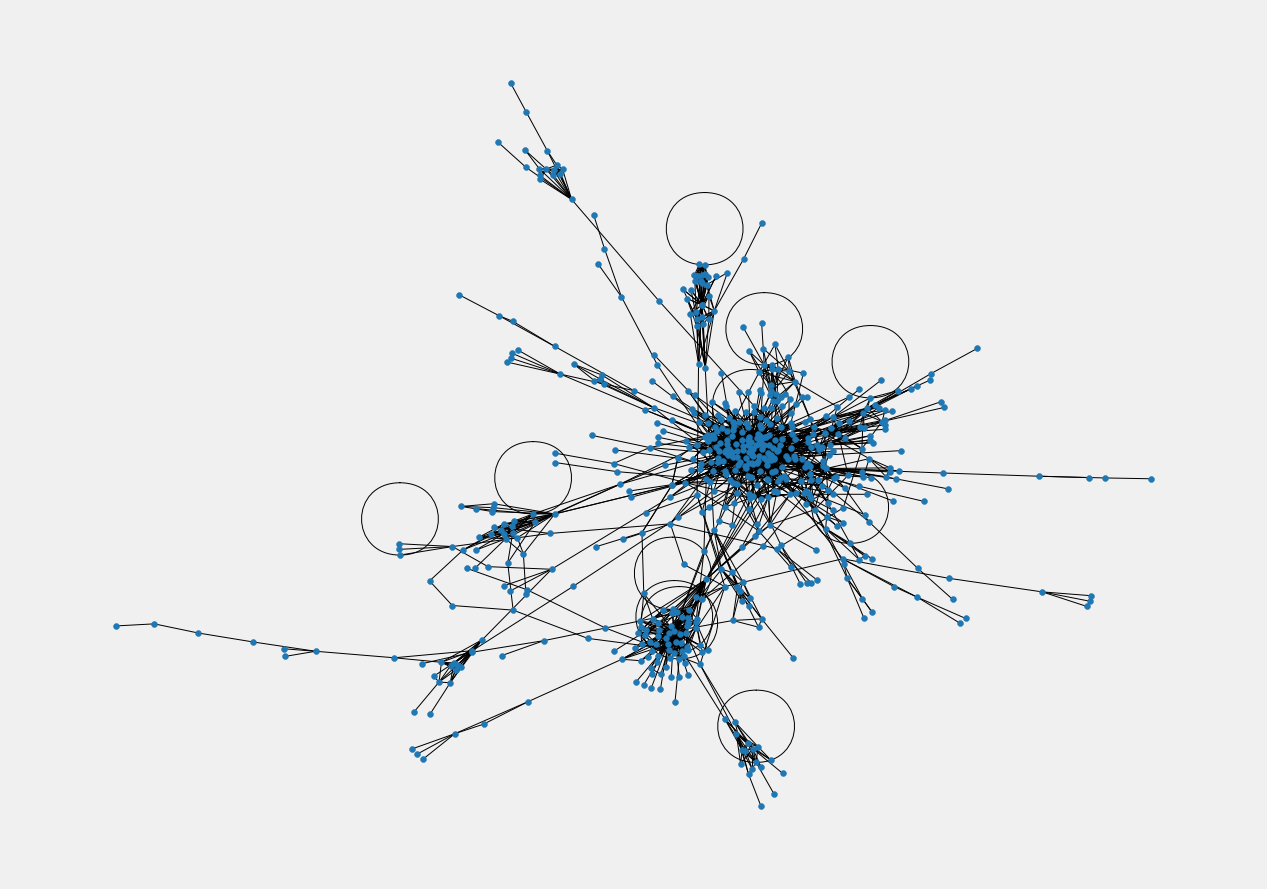

In [8]:
# spring layout graph for aestheti representation of graph (force-anti gravity)
pos = nx.spring_layout(G)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 15)
plt.axis('off')
nx.draw_networkx(G, pos, with_labels = False, node_size = 35)
plt.show()

In [9]:
# exploring the graph and identifying the important nodes
def networkStats(G):
    """
    This function prints the basic properties of the Facebook network.
    """
    print(nx.info(G))
    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    #print(G.nodes['Kamppi (M)'])

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

networkStats(G)

Graph with 620 nodes and 2102 edges
Network density: 0.0109541925061233
Triadic closure: 0.22264084150905228

Top 5 nodes by degree:

('265', 134)
('518', 59)
('67', 56)
('340', 55)
('90', 51)

Top 5 nodes by betweenness centrality:

('265', 0.34990766617377767)
('31', 0.1619605706800918)
('518', 0.14456288292404343)
('618', 0.0932726061636337)
('35', 0.09141807568331686)


In [10]:
# BFS(G,s) returns two dictionaries: the distances and the parents. 
def BFS(G,s):
    
    ## using deque to create a queue object from collections
    queue = deque([s])
    ## initializing the dictionaries
    distance = {s: 0}
    parent = {s: None}
    while queue:
        v = queue.popleft()
        for n in G[v]:
            if n not in distance:            
                queue.append(n)
                # updating the distance of the node
                distance[n] = distance[v] + 1
                # updating the dictionary
                parent[n] = v
    return distance, parent

In [11]:
# number of connected components
def numberOfComponents(G):
    parent = {}
    #Child = []
    count = 0
    for i in G.nodes :
        if i in parent.keys():
            pass
        else:
            count = count + 1 
            distance,parent = BFS(G,i)   
            #n = len(parent) + 1            
            #Child = Child + list(parent.keys()) 
    return count

In [12]:
from collections import deque

In [13]:
BFS(G,'0')

({'0': 0,
  '1': 3,
  '10': 5,
  '100': 5,
  '101': 5,
  '102': 3,
  '103': 5,
  '104': 4,
  '105': 5,
  '106': 5,
  '107': 3,
  '108': 6,
  '109': 4,
  '11': 6,
  '110': 4,
  '111': 3,
  '112': 3,
  '113': 2,
  '114': 4,
  '115': 7,
  '116': 3,
  '117': 7,
  '118': 5,
  '119': 7,
  '12': 4,
  '120': 3,
  '121': 3,
  '122': 4,
  '123': 5,
  '124': 6,
  '125': 3,
  '126': 7,
  '127': 5,
  '128': 3,
  '129': 5,
  '13': 4,
  '130': 3,
  '131': 3,
  '132': 1,
  '133': 4,
  '134': 4,
  '135': 3,
  '136': 3,
  '137': 7,
  '138': 5,
  '139': 5,
  '14': 6,
  '140': 3,
  '141': 7,
  '142': 5,
  '143': 3,
  '144': 7,
  '145': 6,
  '146': 3,
  '147': 7,
  '148': 3,
  '149': 2,
  '15': 3,
  '150': 7,
  '151': 2,
  '152': 6,
  '153': 6,
  '154': 6,
  '155': 3,
  '156': 5,
  '157': 2,
  '158': 6,
  '159': 3,
  '16': 7,
  '160': 4,
  '161': 3,
  '162': 4,
  '163': 6,
  '164': 5,
  '165': 5,
  '166': 3,
  '167': 3,
  '168': 5,
  '169': 3,
  '17': 5,
  '170': 3,
  '171': 3,
  '172': 3,
  '173': 5,
  '1

In [14]:
numberOfComponents(G)

1

## Linear and Integer Programming 

In [15]:
!pip install pulp

     |████████████████████████████████| 14.2 MB 4.5 MB/s 


In [ ]:
# Minimum Vertex cover finds the minimum number of vertices covering all the edges in the graph
def MinimumVertexCover(G):

    ### 
    nodes = list(G.nodes())
    edges = list(G.edges())
    
    # define LP
    prob = LpProblem(name="MinimumVertexCover",sense=LpMinimize)
    
    # variables
    variables = pulp.LpVariable.dicts('nodes',(name for name in nodes),
                                   lowBound=0, upBound=1,
                                   cat=LpInteger)
    
    # constraints 
    for i,j in edges:
        prob += variables[i] + variables[j] >= 1
    
    # objective
    prob += lpSum(variables[i] for i in nodes)
    
    status = prob.solve()
    
    size = value(prob.objective)
    
    sum = 0
    vertices = []
    for i in nodes:
        if variables[i].value() == 1:
          sum = sum + variables[i].value()
          vertices.append(i)

      
    
    return size, vertices

In [17]:
MinimumVertexCover(G)

(286.0,
 ['0',
  '276',
  '58',
  '603',
  '398',
  '555',
  '265',
  '611',
  '182',
  '345',
  '608',
  '377',
  '40',
  '352',
  '450',
  '484',
  '299',
  '65',
  '185',
  '228',
  '227',
  '90',
  '151',
  '394',
  '4',
  '254',
  '5',
  '429',
  '163',
  '486',
  '478',
  '518',
  '7',
  '339',
  '35',
  '583',
  '8',
  '434',
  '98',
  '369',
  '9',
  '317',
  '288',
  '206',
  '593',
  '550',
  '446',
  '89',
  '15',
  '340',
  '248',
  '229',
  '56',
  '570',
  '107',
  '23',
  '465',
  '67',
  '351',
  '498',
  '393',
  '258',
  '11',
  '212',
  '485',
  '264',
  '174',
  '548',
  '618',
  '310',
  '326',
  '70',
  '505',
  '43',
  '432',
  '16',
  '516',
  '119',
  '400',
  '545',
  '334',
  '374',
  '117',
  '274',
  '613',
  '75',
  '418',
  '581',
  '143',
  '599',
  '20',
  '355',
  '238',
  '441',
  '329',
  '22',
  '187',
  '420',
  '128',
  '157',
  '343',
  '24',
  '547',
  '230',
  '502',
  '363',
  '424',
  '147',
  '527',
  '49',
  '126',
  '31',
  '357',
  '507',

## Machine Learning

In [18]:
# Data Preparation
# combine all nodes in a list
node_list = node_list_1 + node_list_2
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [19]:
adj_G

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
adj_G.shape

(620, 620)

In [21]:
#nx.shortest_path_length(G,'0')

In [22]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:16<00:00, 38.36it/s] 


In [23]:
len(all_unconnected_pairs)

19018

In [24]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [67]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
redundant_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    redundant_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:12<00:00, 165.68it/s]


In [68]:
len(redundant_links_index)

1483

In [69]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[redundant_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [70]:
data['link'].value_counts()

0    19018
1     2966
Name: link, dtype: int64

In [28]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [29]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5978 sha256=4af6b9cb372040e6df56cd7a592ceb5a89fff2fe6ec0a818d7e1e82b74703c49
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [30]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


In [32]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

In [33]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [34]:
len(xtrain)

14350

## Logistic Regression

In [35]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced')

In [58]:
predictions = lr.predict_proba(xtest)

In [62]:
roc_auc_score(ytest, predictions[:,1])

0.7968242321738735

In [65]:
lr.score(xtest,ytest)

0.7280117054137538

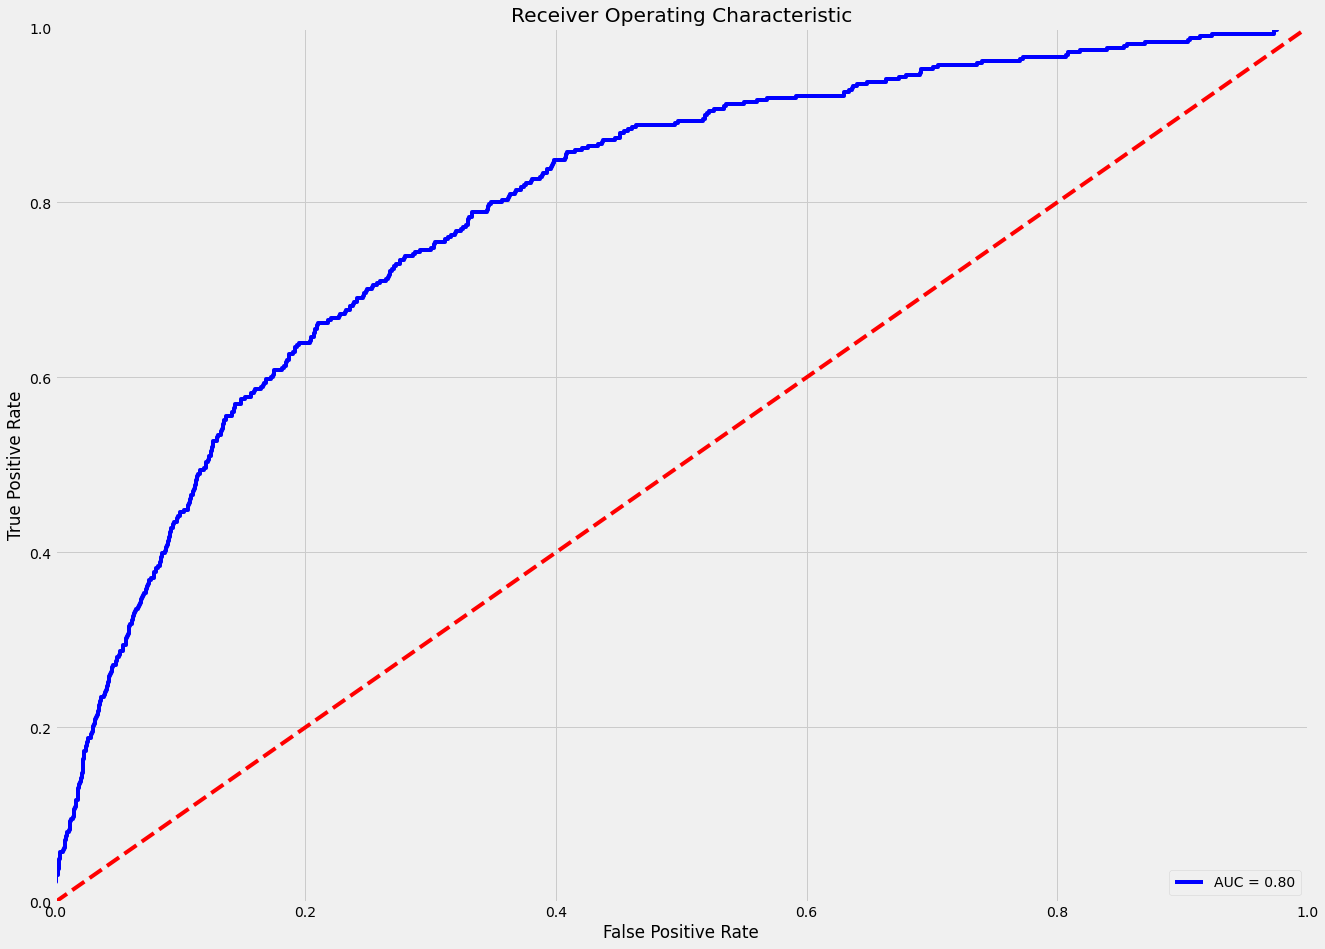

In [42]:
# Compute ROC curve and ROC area for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
preds = predictions[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Decision Tree Classifier

In [43]:
decision_tree = DecisionTreeClassifier(max_depth=10)
decision_tree = decision_tree.fit(xtrain, ytrain)
r = export_text(decision_tree, feature_names=range(100))
print(r)

|--- 21 <= -1.43
|   |--- 68 <= -0.36
|   |   |--- 85 <= -1.89
|   |   |   |--- class: 0
|   |   |--- 85 >  -1.89
|   |   |   |--- 43 <= 2.18
|   |   |   |   |--- 19 <= 0.74
|   |   |   |   |   |--- 40 <= -0.05
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- 40 >  -0.05
|   |   |   |   |   |   |--- 3 <= -0.03
|   |   |   |   |   |   |   |--- 3 <= -0.05
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- 3 >  -0.05
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- 3 >  -0.03
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- 19 >  0.74
|   |   |   |   |   |--- 59 <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- 59 >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- 43 >  2.18
|   |   |   |   |--- 88 <= -0.17
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- 88 >  -0.17
|   |   |   |   |   |--- class: 0
|   |--- 68 >  -0.36
|   |   |--- class: 0
|--- 21 >  -1.43
|   |--- 2

In [44]:
predictions = decision_tree.predict_proba(xtest)

In [45]:
roc_auc_score(ytest, predictions[:,1])

0.677394054710591

In [66]:
decision_tree.score(xtest,ytest)

0.9349699235896602

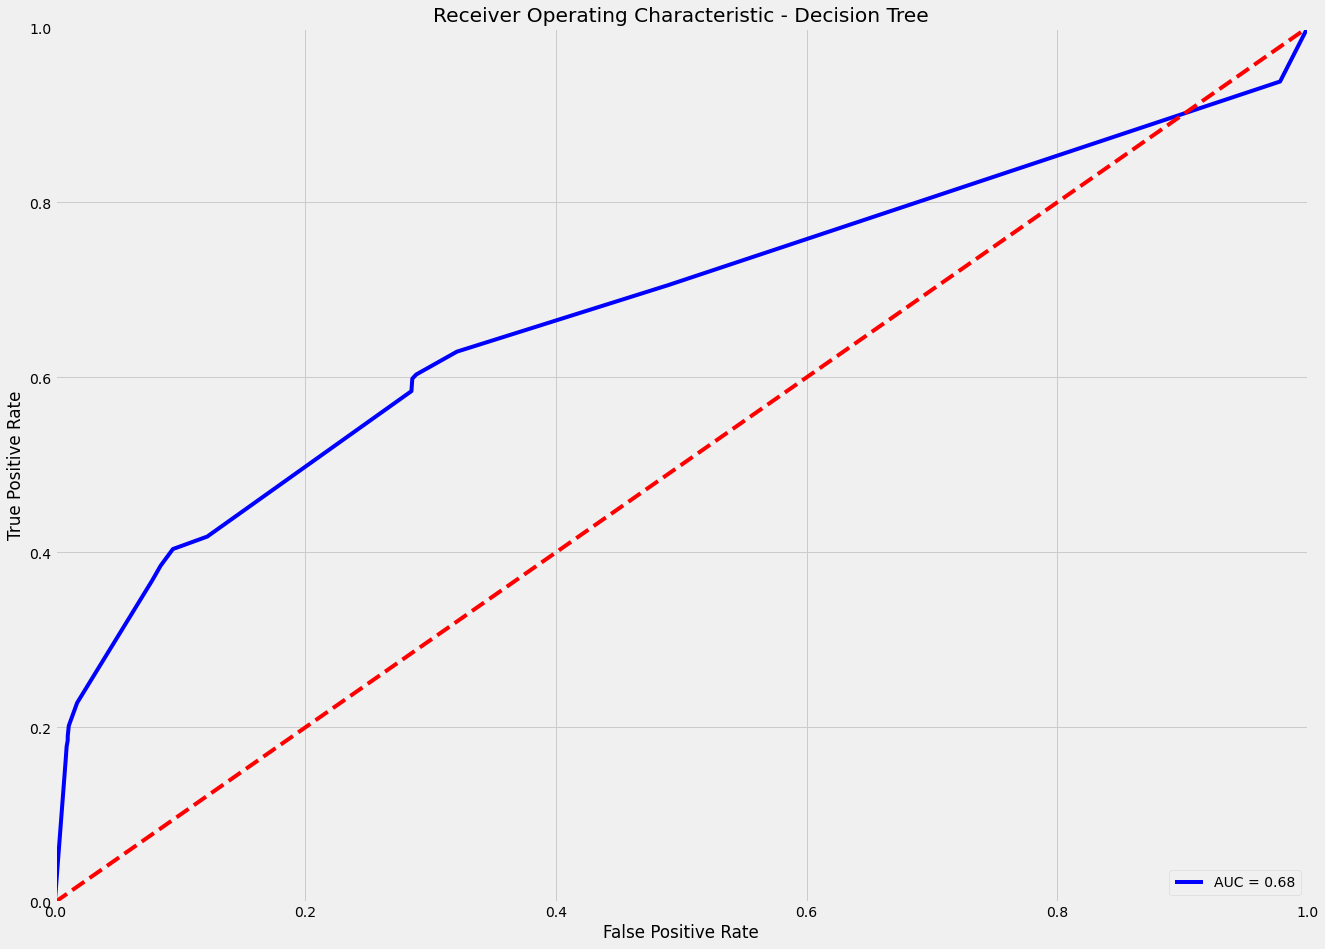

In [57]:
# Compute ROC curve and ROC area for each class
import matplotlib.pyplot as plt
preds = predictions[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Support Vector Machines

In [47]:
SVMmodel = LinearSVC()
# training
SVMmodel.fit(xtrain, ytrain)
y_pred_SVM = SVMmodel.predict(xtest)
# evaluation
acc_SVM = accuracy_score(ytest, y_pred_SVM)
print("SVM model Accuracy: {:.2f}%".format(acc_SVM*100))

SVM model Accuracy: 93.30%


In [48]:
print(roc_auc_score(ytest, y_pred_SVM))

0.5139900013679721


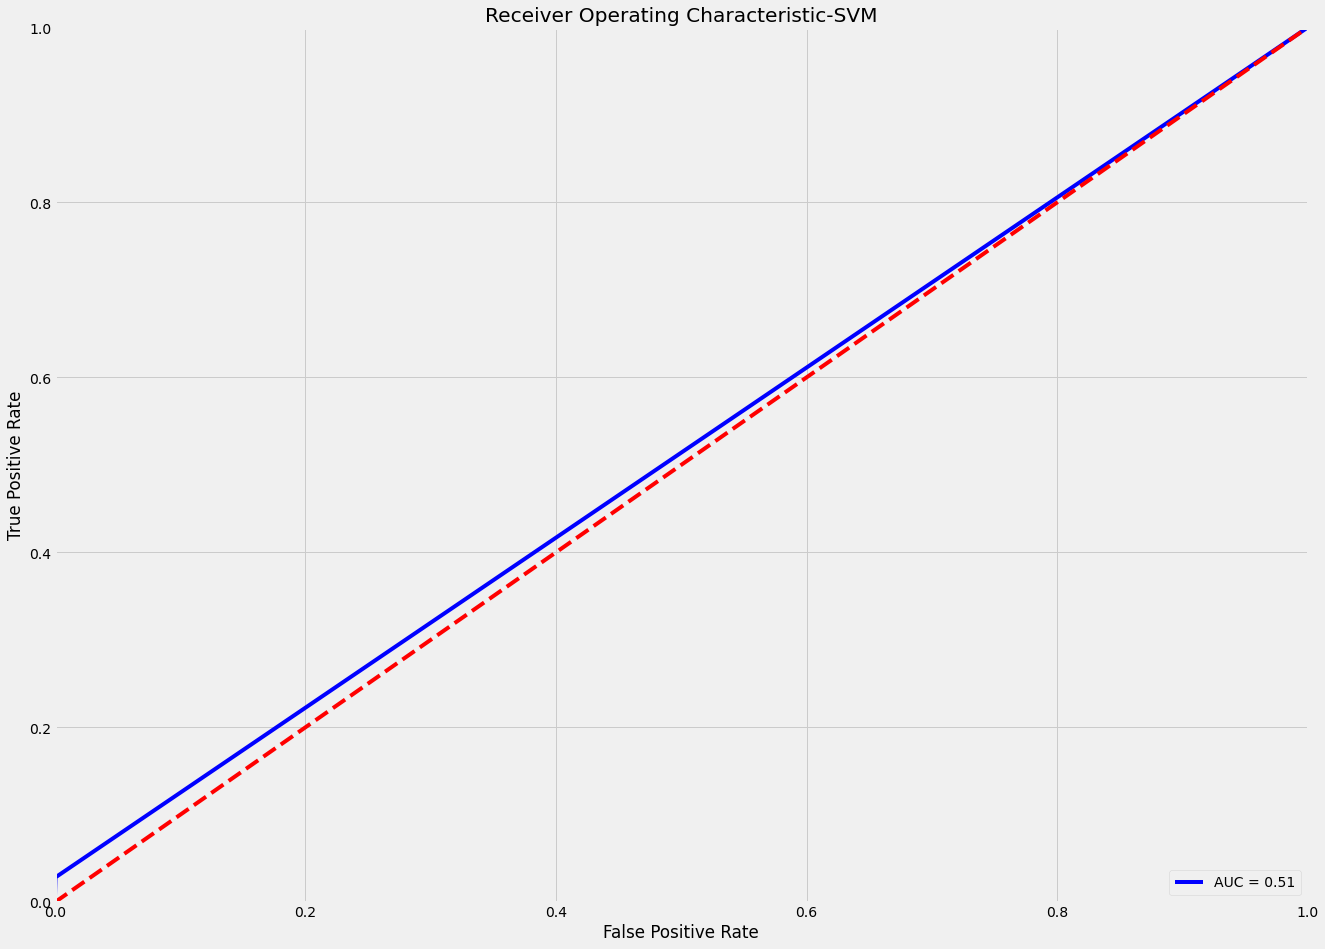

In [56]:
# Compute ROC curve and ROC area for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
preds = y_pred_SVM
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic-SVM')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Decision Tree and Random Forest

In [51]:
DTmodel = DecisionTreeClassifier()
RFmodel = RandomForestClassifier(n_estimators=50, max_depth=3, bootstrap=True, random_state=0) ## number of trees and number of layers/depth
# training
DTmodel.fit(xtrain, ytrain)
y_pred_DT = DTmodel.predict(xtest)
RFmodel.fit(xtrain, ytrain)
y_pred_RF = RFmodel.predict(xtest)
# evaluation
acc_DT = accuracy_score(ytest, y_pred_DT)
print("Decision Tree Model Accuracy: {:.2f}%".format(acc_DT*100))
print(roc_auc_score(ytest, y_pred_DT))
acc_RF = accuracy_score(ytest, y_pred_RF)
print("Random Forest Model Accuracy: {:.2f}%".format(acc_RF*100))
print(roc_auc_score(ytest, y_pred_RF))

Decision Tree Model Accuracy: 91.61%
0.6875794356493515
Random Forest Model Accuracy: 93.35%
0.5164525583149902


In [52]:
## Neural Network and Deep Learning
DLmodel = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,10,10), random_state=1)
# training
DLmodel.fit(xtrain, ytrain)
y_pred_DL= DLmodel.predict(xtest)
# evaluation
acc_DL = accuracy_score(ytest, y_pred_DL)
print("DL model Accuracy: {:.2f}%".format(acc_DL*100))
print(roc_auc_score(ytest, y_pred_DL))

DL model Accuracy: 94.64%
0.7038098021414981


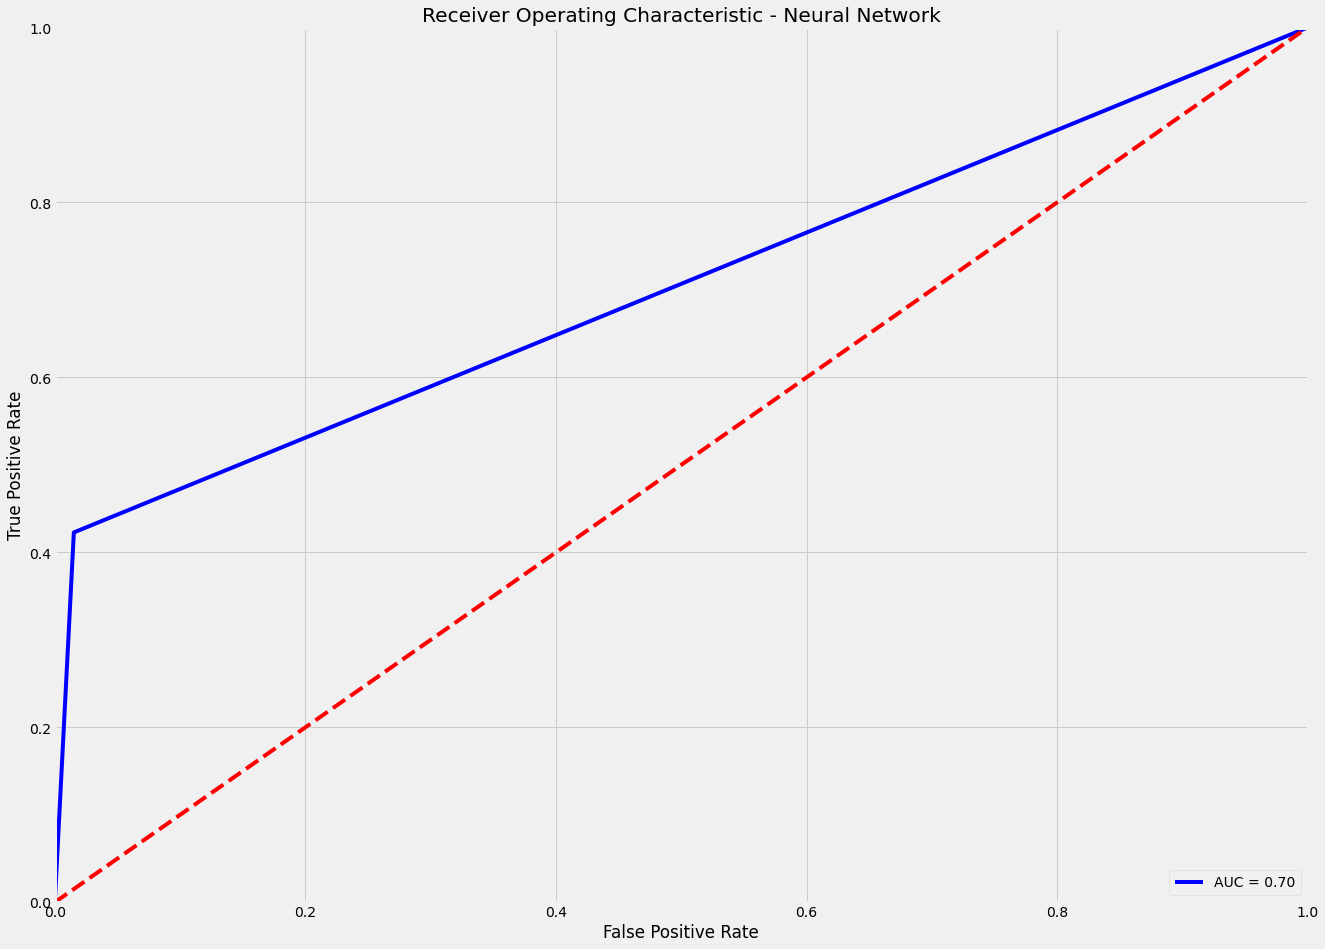

In [55]:
# Compute ROC curve and ROC area for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
preds = y_pred_DL
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Neural Network')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Minimum Spanning Tree

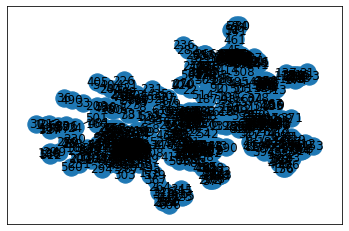

In [ ]:
nx.draw_networkx(nx.minimum_spanning_tree(G))

In [ ]:
print(nx.info(G))

Graph with 620 nodes and 2102 edges
